# MSSW on ELECT2 evaluation

## Accept and preprocess the ELECT2 dataset

In [53]:
import csv

import numpy as np
import pandas as pd
import seaborn as sb

In [54]:
from eval_helpers import accepting

df = pd.read_csv("../Datasets_concept_drift/real_world_data/electricity_dataset.csv")

X = df.drop(columns=['Unnamed: 0', 'label', 'real_date'])
y = df["label"]

X['day'] = X['day'].apply(lambda x: float(x.split('\'')[1]))

print(X.head())
print('DTYPES')
print(X.dtypes)
# X = float(X)
# print(X.head())

print('# nan values in X', np.count_nonzero(np.isnan(X)))

X_ref = X[:15104]
X_test = X[15104:]
y_ref = y[:15104]
y_test = y[15104:]

print('remaining columns')
print(X_ref.columns)

X_ref = X_ref.to_numpy()
X_test = X_test.to_numpy()
y_ref = y_ref.to_numpy()
y_test = y_test.to_numpy()

print('\nreference data')
print(X_ref.shape)
print(X_ref)
print('\nreference labels')
print(y_ref.shape)
print('\ntesting data')
print(X_test.shape)
print(X_test)
print('\ntesting labels')
print(y_test.shape)

   date  day    period  nswprice  nswdemand  vicprice  vicdemand  transfer
0   0.0  2.0  0.000000  0.056443   0.439155  0.003467   0.422915  0.414912
1   0.0  2.0  0.021277  0.051699   0.415055  0.003467   0.422915  0.414912
2   0.0  2.0  0.042553  0.051489   0.385004  0.003467   0.422915  0.414912
3   0.0  2.0  0.063830  0.045485   0.314639  0.003467   0.422915  0.414912
4   0.0  2.0  0.085106  0.042482   0.251116  0.003467   0.422915  0.414912
DTYPES
date         float64
day          float64
period       float64
nswprice     float64
nswdemand    float64
vicprice     float64
vicdemand    float64
transfer     float64
dtype: object
# nan values in X 0
remaining columns
Index(['date', 'day', 'period', 'nswprice', 'nswdemand', 'vicprice',
       'vicdemand', 'transfer'],
      dtype='object')

reference data
(15104, 8)
[[0.       2.       0.       ... 0.003467 0.422915 0.414912]
 [0.       2.       0.021277 ... 0.003467 0.422915 0.414912]
 [0.       2.       0.042553 ... 0.003467 0.422915

## Split the dataset to batches (size=365)

In [55]:
from eval_helpers import helpers

X_test_batches_year, y_test_batches_year = helpers.split_to_fixed_size_batches(X_test, y_test, batch_size=365)
X_ref_batches_year, y_ref_batches_year = helpers.split_to_fixed_size_batches(X_ref, y_ref, batch_size=365)

print('# yearly test batches:')
print(len(X_test_batches_year))
print(len(y_test_batches_year))
print('# yearly ref batches:')
print(len(X_ref_batches_year))
print(len(y_ref_batches_year))

chunk size 365
number of chunks 82
number of data 30208
shape of X that can be split perfectly (29930, 8)
number of resulting batches 82
[[0.434052 1.       0.680851 ... 0.003467 0.422915 0.414912]
 [0.434052 1.       0.702128 ... 0.003467 0.422915 0.414912]
 [0.434052 1.       0.723404 ... 0.003467 0.422915 0.414912]
 ...
 [0.434406 2.       0.212766 ... 0.003467 0.422915 0.414912]
 [0.434406 2.       0.234043 ... 0.003467 0.422915 0.414912]
 [0.434406 2.       0.255319 ... 0.003467 0.422915 0.414912]]
(365, 8)
chunk size 365
number of chunks 41
number of data 15104
shape of X that can be split perfectly (14965, 8)
number of resulting batches 41
[[0.00000e+00 2.00000e+00 0.00000e+00 ... 3.46700e-03 4.22915e-01
  4.14912e-01]
 [0.00000e+00 2.00000e+00 2.12770e-02 ... 3.46700e-03 4.22915e-01
  4.14912e-01]
 [0.00000e+00 2.00000e+00 4.25530e-02 ... 3.46700e-03 4.22915e-01
  4.14912e-01]
 ...
 [3.10000e-04 2.00000e+00 5.53191e-01 ... 3.46700e-03 4.22915e-01
  4.14912e-01]
 [3.10000e-04 2.

## Find suitable KMeans clustering parameters

In [51]:
import importlib
from core import mssw_preprocessing
from eval_helpers import kmeans_verbose_helpers
importlib.reload(mssw_preprocessing)

weighted_joined_reference_data, _, _ = mssw_preprocessing.mssw_preprocess(X_ref_batches_year, X_test_batches_year)
# print(print('# nan values in wjrd', np.count_nonzero(np.isnan(weighted_joined_reference_data))))

filename = 'elect2_output.txt'
print(kmeans_verbose_helpers)
kmeans_verbose_helpers.write_verbose_kmeans_to_file(filename, weighted_joined_reference_data,
                                                    n_clusters=10, n_init=100, max_iter=500, tol=0, random_state=1053)
output_dicts = kmeans_verbose_helpers.convert_kmeans_output_file_to_dicts(filename, n_init=100)
kmeans_verbose_helpers.print_stats_from_kmeans_output_dicts(output_dicts)

<module 'eval_helpers.kmeans_verbose_helpers' from 'C:\\Users\\jpohl\\PycharmProjects\\clustering-drift-detection\\mssw\\eval_helpers\\kmeans_verbose_helpers.py'>
random state: 1053
total number of results: 100
maximum number of iterations: 12
minimum initial inertia: 19.84713208349392
maximum initial inertia: 38.73653887770708
number of unique final inertia values: 6
minimum final inertia: 17.439267125234473
maximum final inertia: 20.951295696041562
total number of convergences: 100
number of strict convergences: 100
number of tol-based convergences: 0


## Try different numbers of clusters

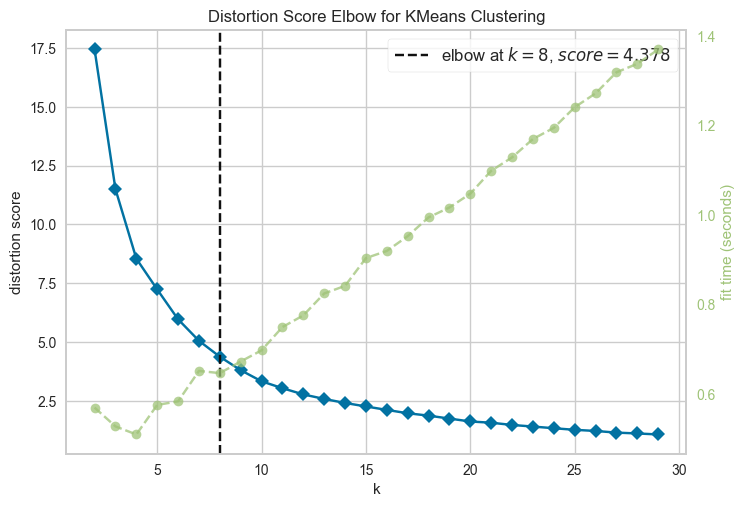

KElbowVisualizer(ax=<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(max_iter=10000, n_clusters=29, n_init=100,
                                  random_state=0, tol=0),
                 k=(2, 30))

In [52]:
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.datasets.loaders import load_nfl
from sklearn.cluster import KMeans


kmeans = KMeans(
    n_init=100,
    max_iter=10000,
    tol=0,
    random_state=0
)

kelbow_visualizer(kmeans, weighted_joined_reference_data, k=(2, 30))

## Inspect one run of MSSW

In [56]:
from core import mssw
import importlib
importlib.reload(mssw)
from matplotlib import pyplot as plt


drifts_detected, LCL_Av_s, UCL_Av_s, all_av_c, all_av_sr, all_cluster_num_points = \
    mssw.all_drifting_batches_return_plot_data(
        X_ref_batches_year,
        X_test_batches_year,
        n_clusters=10,
        n_init=100,
        max_iter=100,
        tol=0,
        random_state=0
    )

print('# drifts detected', np.sum(drifts_detected))
print('lower bound', LCL_Av_s)
print('upper bound', UCL_Av_s)
# print('all_av_c', all_av_c)
print('all_av_sr', all_av_sr)
print('reference av_sr', all_av_sr[:, :len(X_ref_batches_year)])



mean_av_s 148.63215745413504
mean_mr 14.353964361763346
# drifts detected 82
lower bound 110.45061225184455
upper bound 186.81370265642553
all_av_sr [[9.17415084e-02 3.58862137e-01 7.64441184e-01 4.05177114e+00
  5.64661835e+00 6.09451806e+00 6.53930462e+00 1.01294820e+01
  1.15299543e+01 1.19742916e+01 1.24223328e+01 1.56590393e+01
  1.73542467e+01 1.78012334e+01 1.82457979e+01 2.11733577e+01
  2.31806399e+01 2.36264696e+01 2.40732266e+01 2.72599696e+01
  2.90666567e+01 2.95111742e+01 2.99563238e+01 3.27962335e+01
  3.48915968e+01 3.53376874e+01 3.57835245e+01 3.88814033e+01
  4.07783658e+01 4.12232261e+01 4.16701771e+01 3.38363433e+02
  5.62418833e+02 5.62865937e+02 5.63310467e+02 5.65751506e+02
  5.68247144e+02 5.68691864e+02 5.69139021e+02 5.73006267e+02
  5.74250316e+02 5.74865556e+02 5.75776523e+02 5.79801954e+02
  5.80246486e+02 5.80693461e+02 5.81835577e+02 5.85649456e+02
  5.86075300e+02 5.86519703e+02 5.86966424e+02 5.91301178e+02
  5.91901499e+02 5.92348450e+02 5.92860461e+0